# Algorytm Gaussa-Jordana 

In [1]:
import numpy as np
import time

In [2]:
def gauss_jordan(A, B):
    npA = np.array(A, dtype=np.float64)
    npB = np.array(B, dtype=np.float64)
    n = len(B)
    for col in range(n):
        pivot_row_idx = max(range(col, n), key = lambda idx: abs(npA[idx, col]))
        npA[[pivot_row_idx, col]] = npA[[col, pivot_row_idx]]
        npB[[pivot_row_idx, col]] = npB[[col, pivot_row_idx]]
        npB[col] /= npA[col,col]
        npA[col] /= npA[col, col]
        npA[col,col] = 1.0
        for row in range(0, n):
            if row != col:
                npB[row] -= npA[row, col]*npB[col]
                npA[row] -= npA[row, col]*npA[col]
                npA[row, col] = 0.0
    return npB

In [3]:
sizes = [800, 1100, 1400, 1700, 2000]
times = []
for s in sizes:
    A = np.random.uniform(-500, 500, size=(s, s))
    B = np.random.uniform(-500, 500, size=(s, s))
    
    start_gauss = time.time()
    result_gauss = gauss_jordan(A, B)
    end_gauss = time.time()
    
    start_np = time.time()
    result_np = np.linalg.solve(A, B)
    end_np = time.time()
    
    times.append((end_gauss - start_gauss, end_np - start_np))

In [4]:
for size, (t1, t2) in zip(sizes, times):
    print("\t\tmacierz rozmiaru{}x{}".format(size, size))
    print("Czas Gauss_Jordan:    {}".format(t1))
    print("Czas np.linalg.solve: {}\n".format(t2))

		macierz rozmiaru800x800
Czas Gauss_Jordan:    6.503441572189331
Czas np.linalg.solve: 0.02796006202697754

		macierz rozmiaru1100x1100
Czas Gauss_Jordan:    11.081290006637573
Czas np.linalg.solve: 0.040991783142089844

		macierz rozmiaru1400x1400
Czas Gauss_Jordan:    19.812318086624146
Czas np.linalg.solve: 0.07399797439575195

		macierz rozmiaru1700x1700
Czas Gauss_Jordan:    30.874306440353394
Czas np.linalg.solve: 0.19500088691711426

		macierz rozmiaru2000x2000
Czas Gauss_Jordan:    46.49920058250427
Czas np.linalg.solve: 0.348921537399292



# Faktoryzacja LU

In [5]:
def lu(A):
    L = np.zeros(A.shape, dtype=np.float64)
    U = np.zeros(A.shape, dtype=np.float64)

    for i in range(len(A)):
        L[i][i] = 1.0

        for j in range(i+1):
            U[j][i] = A[j][i] - np.sum([U[x][i] * L[j][x] for x in range(j)])

        for j in range(i+1, len(A)):
            L[j][i] = (A[j][i] - np.sum([U[x][i] * L[j][x] for x in range(i)])) / U[i][i]
            
    return (L, U)

In [6]:
A = np.array([
    [4, -2, -3, 1],
    [1, 3, 1, 3],
    [1, 2, -1, -2],
    [2, 1, -1, -1.]
])
L, U = lu(A)
print(L@U)

[[ 4. -2. -3.  1.]
 [ 1.  3.  1.  3.]
 [ 1.  2. -1. -2.]
 [ 2.  1. -1. -1.]]


In [7]:
np.linalg.norm(A - L@U)

1.1102230246251565e-16

# Analiza obwodu elektrycznego

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy as sp

### Funkcja wczytująca graf z pliku

In [9]:
def read_graph(filename):
    G = nx.DiGraph()
    S = None
    T = None
    E = None
    with open(filename) as file:
        lines = file.readlines()
        for line in lines:
            args = line.split(" ")
            if args[0] == "STE":
                S = int(args[1])
                T = int(args[2])
                E = int(args[3])
            else:
                node1 = int(args[0])
                node2 = int(args[1])
                R = int(args[2])
                G.add_edge(node1, node2, R=R)

    return (G, S, T, E) 

### Weryfikacja rozwiązania na podstawie I Prawa Kirchoffa

Podstawowa weryfikacja polega na zastosowaniu dla każdego węzła I prawa Kirchoffa i sprawdzenie czy suma prądów wchodzących jest równa sumie prądów wychodzących.

In [10]:
def test_KCL(G, S, T, currents, eps=1e-4):
    for node in G.nodes():
        sum_in = 0
        sum_out = 0
        for edge in G.in_edges():
            sum_in += currents[edge]
        for edge in G.out_edges():
            sum_out += currents[edge]

        if abs(sum_in - sum_out) > eps:
            print("Test for KCL: FAIL")
            print("Node {}:".format(node))
            print("current in: {}".format(sum_in))
            print("current out: {}".format(sum_out))
            return False

    print("Test for KCL: PASS")
    return True

### Szukanie prądów w obwodzie

Funckja solve_kirchoff() znajduje natężenia w obwodzie za pomocą praw kirchoffa oraz nadokreślonego układu równań.
- I Prawo Kirchoffa

    Dla każdego węzła obwodu elektrycznego suma algebraiczna natężeń prądów wpływających (+) i wypływających (−) jest równa zeru. Stosując to prawo dla każdego węzła obwodu (węzeł S i T traktuje jako jeden) otrzymuję |V| - 1 równań
    
    
- II Prawo Kirchoffa
    
    W każdym oczku (cyklu prostym) obwodu, suma spadków napięć jest równa sumie sił elektromotorycznych w tym oczku.
    Znajdując wszystkie cykle proste w grafie (przy pomocy funkcji networkx.cycle_basis), oraz stosując dla nich powyższe prawo, otrzymujemy |E|-|V|+1 równań. Dodając do tego dowolny cykl zawierający SEM (w tym przypadku krawędź łączącą S i T, lub w przypadku jej braku dowolną ścieżkę pomiędzy tymi wierzchołkami) otrzymujemy |E|-|V|+2 równań.
    
- Z połączenia obydwu praw Kirchoffa otrzymujemy nadokreślony układ |E|+1 równań z |E| niewiadomymi który przy pomocy funkcji scipy.linalg.lstsq jest rozwiązywany metodą najmniejszych kwadratów
    

Funkcja nodal_analysis znajduje prądy w obwodzie w dwóch krokach:
- W pierwszym kroku stosowana jest metoda potencjałów węzłowych w celu znalezienia potencjału każdego węzła. Za potencjał w punkcie S przyjmuję E (podane napięcie) a w punkcie T 0. Dla pozostałych |V|-2 węzłów stosuję I prawo Kirchoffa otrymując |V|-2 równań z |V|-2 niewiadomymi który rowiązuję funkcją biblioteczną numpy.linalg.solve.

- Znając już potencjał każdego węzła obwodu, w drugim kroku przechodząc po każdej gałęzi obwodu, obliczam natężenie prądu w niej płynącego.

Jako że w obydwu metodach początkowe zwroty natężeń przyjęte są losowo, natężenia wyliczane są dokładne co do ich wartości
bezwzględnej. Oznacza to że jeśli natężenie wyszło ujemne- rzeczywisty zwrot natężenia (krawędzi) powinien być przeciwny.

In [11]:
def solve_kirchoff(G, S, T, E):
    edge_idx = {}
    idx_edge = []

    for idx, edge in enumerate(G.edges()):
        edge_idx[edge] = idx
        idx_edge.append(edge)

    size = len(idx_edge)
    A = []
    B = []

    # KCL
    # all nodes except for S and T
    for node in G.nodes():
        if node != S and node != T:
            line = np.zeros(shape=size)
            for edge in list(G.in_edges(node)):
                line[edge_idx[edge]] = 1
            for edge in G.out_edges(node):
                line[edge_idx[edge]] = -1
            A.append(line)
            B.append(0)
    
    # S and T 
    line = np.zeros(shape=size)
    for edge in list(G.in_edges(S)) + list(G.in_edges(T)):
        if edge != (S, T) and edge != (T, S):
            line[edge_idx[edge]] = 1

    for edge in list(G.out_edges(S)) + list(G.out_edges(T)):
        if edge != (S, T) and edge != (T, S):
            line[edge_idx[edge]] = -1
        
    A.append(line)
    B.append(0)

    # KVL
    cycles = nx.cycle_basis(G.to_undirected())
    R = nx.get_edge_attributes(G,'R')
    for c in cycles:
        line = np.zeros(shape=size) 
        for i in range(len(c) - 1):
            #if edge exist
            if c[i+1] in G[c[i]]: 
                edge = (c[i], c[i+1])
                line[edge_idx[edge]] = R[edge]
            else:
                edge = (c[i+1], c[i])
                line[edge_idx[edge]] = -R[edge]

        if c[0] in G[c[-1]]: 
            edge = (c[-1], c[0])
            line[edge_idx[edge]] = R[edge]
        else:
            edge = (c[0], c[-1])
            line[edge_idx[edge]] = -R[edge]
        A.append(line)
        B.append(0)

    # add eguation for the cicle with the source 
    line = np.zeros(shape=size) 
    if S in G[T]:
        edge = (T, S)
        line[edge_idx[edge]] = R[edge]
    elif T in G[S]:
        edge = (S, T)
        line[edge_idx[edge]] = -R[edge]
    else:
        path = next(nx.all_simple_paths(G.to_undirected(), source=S, target=T))
        if path:
            for i in range(len(path) - 1):
                #if edge exist
                if path[i+1] in G[path[i]]: 
                    edge = (path[i], path[i+1])
                    line[edge_idx[edge]] = R[edge]
                else:
                    edge = (path[i+1], path[i])
                    line[edge_idx[edge]] = -R[edge]
        else:
            raise RuntimeError("There is no connection between S and T") 

    A.append(line)
    B.append(E)
    solution = sp.linalg.lstsq(A, B)[0] 
    currents = {idx_edge[i]: solution[i] for i in range(size)}
    test_KCL(G, S, T, currents)
    return currents

In [12]:
def nodal_analysis(G, S, T, E):
    A = []
    B = []
    G_un = G.to_undirected()
    # asign variable index to nodes
    id = {}
    size = 0
    for n in G.nodes():
        if n not in [S, T]:
            id[n] = size
            size += 1

    R = nx.get_edge_attributes(G_un,'R')
    get_r = lambda edge: R[edge] if edge in R else R[edge[::-1]]

    for u in G_un.nodes():
        line = np.zeros(shape=size) 
        b = 0
        if u not in [S, T]:
            for v in G_un.neighbors(u):
                r = get_r((u, v))
                if v == S:
                    b = E/r 
                elif v != T:
                    line[id[v]] = -1/r
                line[id[u]] += 1/r
            A.append(line)
            B.append(b)

    voltage  = np.linalg.solve(A, B)
    def get_volt(v):
        if v == S:
            return E
        elif v == T:
            return 0
        return voltage[id[v]]
    
    currents = {(u, v): (get_volt(v) - get_volt(u))/get_r((u, v)) for (u, v) in G.edges()}
    test_KCL(G, S, T, currents)
    return currents

In [13]:
def fix_current_direction(G, currents):
    R = nx.get_edge_attributes(G,'R')
    for edge in list(G.edges()):
        if currents[edge] < 0:
            G.add_edge(edge[1], edge[0], R=R[edge])
            G.remove_edge(edge[0], edge[1])
            currents[edge[::-1]] = -currents.pop(edge)
    
    return G

### Visualization

Wierzchołki S i T zostają oznaczone na kolor czerwony, a intensywność koloru krawędzi informuje o płynącym natężeniu. Im kolor bardziej intensywny, tym większe jest natężenie.

In [14]:
def draw_circut(G, S, T, E, method=nodal_analysis):
    currents = method(G, S, T, E)
    G = fix_current_direction(G, currents)

    # S, T -> red
    col = lambda idx: 'red' if idx == S or idx == T else '#1f78b4'
    color_map = [col(i) for i in G]
    weights = [math.log(6 + c, 3) for c in currents.values()]

    pos2 = nx.spring_layout(
        G, 
        k = 15 / np.sqrt(G.number_of_nodes()),
        iterations=800
    )
    nx.draw(
        G, 
        pos=pos2,
        node_color=color_map, 
        with_labels=True, 
        edge_color=weights, 
        edge_cmap=plt.cm.Reds,
        node_size=100,
        font_size=8
        )
    plt.show()

### Spójny graf losowy


15 wierzchołków

Test for KCL: PASS


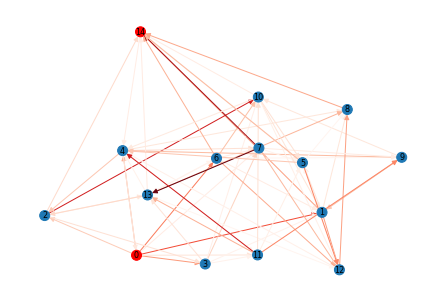

In [15]:
G, S, T, U = read_graph("erdos_15")
draw_circut(G, S, T, U, method=solve_kirchoff)

80 wierzchołków

Test for KCL: PASS


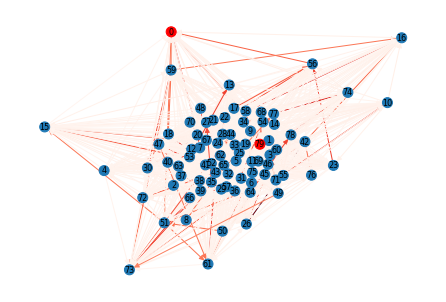

In [16]:
G, S, T, U = read_graph("erdos_80")
draw_circut(G, S, T, U, method=nodal_analysis)

150 wierzchołków

Test for KCL: PASS


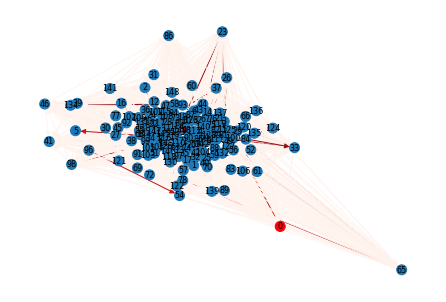

In [17]:
G, S, T, U = read_graph("erdos_150")
draw_circut(G, S, T, U, method=nodal_analysis)

### Graf 3-regularny

16 wierzchołków

Test for KCL: PASS


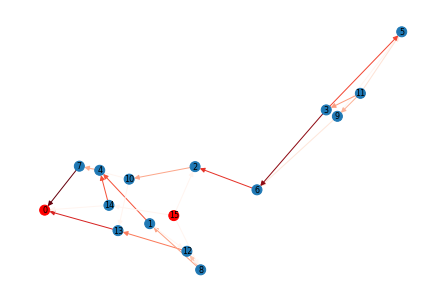

In [18]:
G, S, T, U = read_graph("reg3_16")
draw_circut(G, S, T, U, method=nodal_analysis)

80 wierzchołków

Test for KCL: PASS


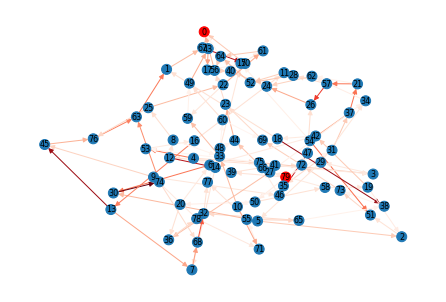

In [19]:
G, S, T, U = read_graph("reg3_80")
draw_circut(G, S, T, U, method=nodal_analysis)

200 werzchołków

Test for KCL: PASS


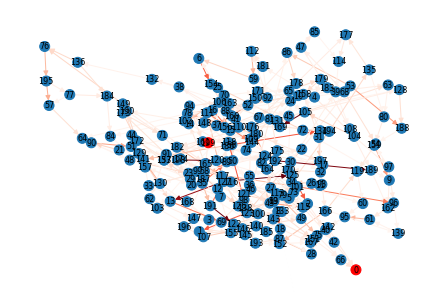

In [20]:
G, S, T, U = read_graph("reg3_200")
draw_circut(G, S, T, U, method=nodal_analysis)

### 2 grafy losowe połączone mostkiem

Test for KCL: PASS


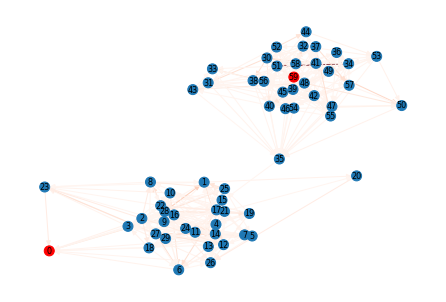

In [21]:
G, S, T, E = read_graph("bridges2_60")
draw_circut(G, S, T, E, method=nodal_analysis)

### Graf siatka 2D

Siatka 5x5

Test for KCL: PASS


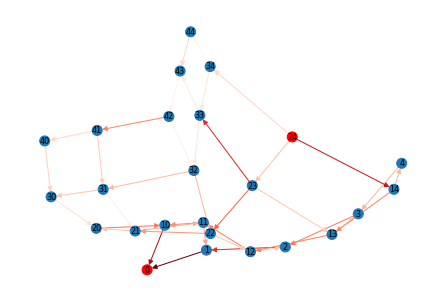

In [22]:
G, S, T, E = read_graph("mesh5_5")
draw_circut(G, S, T, E, method=nodal_analysis)

Siatka 10x10

Test for KCL: PASS


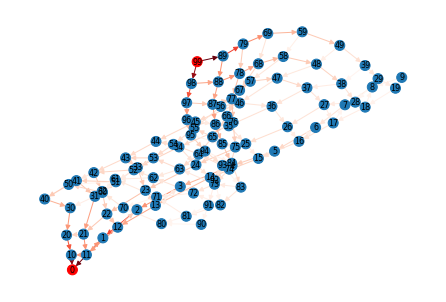

In [23]:
G, S, T, E = read_graph("mesh10_10")
draw_circut(G, S, T, E, method=nodal_analysis)

### Graf typu small-world

15 wierzchołków

Test for KCL: PASS


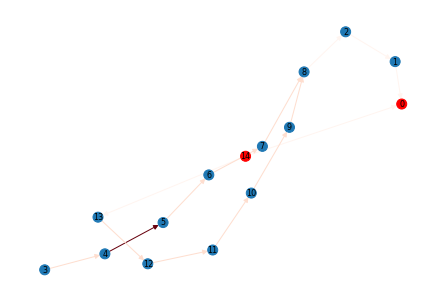

In [24]:
G, S, T, E = read_graph("small_world_15")
draw_circut(G, S, T, E, method=nodal_analysis)

80 wierzchołków

Test for KCL: PASS


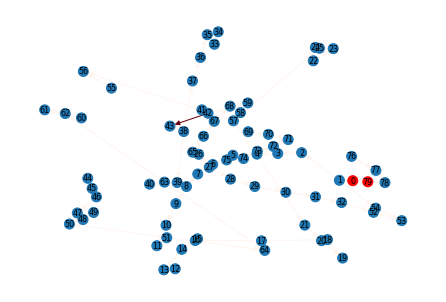

In [33]:
G, S, T, E = read_graph("small_world_80")
draw_circut(G, S, T, E, method=nodal_analysis)

150 wierzchołków

Test for KCL: PASS


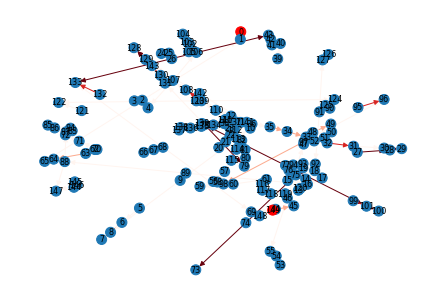

In [41]:
G, S, T, E = read_graph("small_world_150")
draw_circut(G, S, T, E, method=nodal_analysis)